In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import img_to_array, load_img, to_categorical
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# Define image dimentions
img_width, img_height = 96, 96

# Function to load and preprocess images
def preprocess_images(folder_path):
    X = []
    y = []
    for folder in sorted(os.listdir(folder_path)):
        if not os.path.isdir(os.path.join(folder_path, folder)):
            continue
        for image_name in os.listdir(os.path.join(folder_path, folder)):
            image_path = os.path.join(folder_path, folder, image_name)
            image = load_img(image_path, target_size=(img_width, img_height))
            image = img_to_array(image)
            X.append(image)
            y.append(folder)

    X = np.array(X)
    y = np.array(y)

    return X, y

path_to_main_folder = "/content/drive/MyDrive/img" # This is where I put data, after download
X_orig, y_orig = preprocess_images(path_to_main_folder)

# Change the numeric class labels from 1-10 to 0-9
y_orig = np.array([int(i)-1 for i in y_orig])

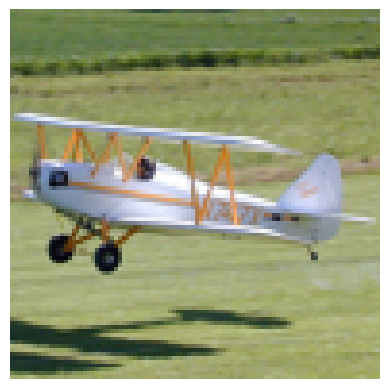

In [4]:
# Show data sample
plt.imshow(X_orig[0].astype('uint8'))
plt.axis('off')
plt.show()

In [5]:
# Clear any remaining sessions and set seed
tf.keras.backend.clear_session()
keras.utils.set_random_seed(767)

# Create copies of data and drop monkey (label "7") class as there is no monkey class in other dataset
X = X_orig.copy()
y = y_orig.copy()

X = X[y != 7]
y = y[y != 7]

# Apply one hot encoding and remove masked element column
y = to_categorical(y)
selected_classes = [0,1,2,3,4,5,6,8,9]
y = y[:, selected_classes]

In [6]:
# Split into train, test, and validation sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2)

# Normalize data
X_train_full = X_train_full/255.0
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

# Print data and shapes
print(y_train.shape, y_valid.shape, y_test.shape)
print(X_train.shape, X_valid.shape, X_test.shape)

(2886, 9) (722, 9) (902, 9)
(2886, 96, 96, 3) (722, 96, 96, 3) (902, 96, 96, 3)


In [7]:
# Instantiate early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15, restore_best_weights=True)

# Create data augmentation sequential object
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.05),
    tf.keras.layers.RandomContrast(factor=0.2)
])

In [8]:
# Build convolutional neural network model hyperparameter tuner
def build_model(hp, input_shape):

    n_filters = hp.Int("n_filters", min_value=32, max_value=96, step=32)
    n_neurons = hp.Choice('n_nodes', values=[128, 256, 512, 1024])

    learning_rate = hp.Float("learning_rate", min_value = 1e-3, max_value = 1e-1, sampling = "log")
    optimizer = hp.Choice("optimizer", values = ["Nesterov", "Adam", "RMSProp"])

    if optimizer == "Nesterov":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = .9,
                                           nesterov = True)
    elif optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = .9,
                                           beta_2 = .999)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate, rho = .9)

    model = keras.Sequential()
    model.add(data_augmentation)
    model.add(Conv2D(n_filters, kernel_size=3, input_shape=input_shape, padding="same",
                       activation="relu", kernel_initializer="he_normal"))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())
    for i in range(hp.Int('n_conv_pairs', 1, 3)):
        n_filters *= 2
        model.add(Conv2D(filters = n_filters, kernel_size=3, padding="same",
                       activation="relu", kernel_initializer="he_normal"))
        model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

    model.add(Flatten())
    for i in range(hp.Int('n_dense', 1, 3)):
        model.add(Dense(n_neurons, activation = "relu", kernel_initializer="he_normal"))
        n_neurons /= 2
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
    model.add(Dense(9, activation = "softmax"))

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [9]:
# Define input shape variable
input_shape = X_train.shape[1:]
print(input_shape)
#b_model = build_model(input_shape = input_shape) # Failed attempt to use input_shape parameter

# Instantiate random search tuner
random_search_tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape),
    objective='val_accuracy',
    max_trials=5,
    directory='STL10_model_search',
    project_name='STL10_tuner')

# Initiate search and get best model hyperparameters
random_search_tuner.search(x=X_train,
             y=y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_valid, y_valid))

model = random_search_tuner.get_best_models(num_models=1)[0]

# Fit model with full training data, show evaluation metrics, and save model
history = model.fit(X_train_full, y_train_full, epochs=30, validation_data=(X_test, y_test),
                    callbacks=[early_stopping_cb])
model.summary()

loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', round(loss, 2))
print('Accuracy:', round(accuracy, 2))
model.save('/content/drive/MyDrive/Colab Notebooks/STL10_model', overwrite=True, save_format='tf')

Trial 5 Complete [00h 00m 59s]
val_accuracy: 0.619113564491272

Best val_accuracy So Far: 0.619113564491272
Total elapsed time: 00h 07m 40s
Epoch 1/30
113/113 [==============================] - 9s 37ms/step - loss: 0.7855 - accuracy: 0.7137 - val_loss: 1.7089 - val_accuracy: 0.4956
Epoch 2/30
113/113 [==============================] - 3s 27ms/step - loss: 0.7438 - accuracy: 0.7306 - val_loss: 1.0628 - val_accuracy: 0.6397
Epoch 3/30
113/113 [==============================] - 3s 30ms/step - loss: 0.6738 - accuracy: 0.7666 - val_loss: 1.0853 - val_accuracy: 0.6286
Epoch 4/30
113/113 [==============================] - 4s 32ms/step - loss: 0.6222 - accuracy: 0.7719 - val_loss: 0.9173 - val_accuracy: 0.6785
Epoch 5/30
113/113 [==============================] - 3s 29ms/step - loss: 0.5961 - accuracy: 0.7838 - val_loss: 0.9149 - val_accuracy: 0.6785
Epoch 6/30
113/113 [==============================] - 3s 29ms/step - loss: 0.5678 - accuracy: 0.7974 - val_loss: 1.1122 - val_accuracy: 0.6397
Ep

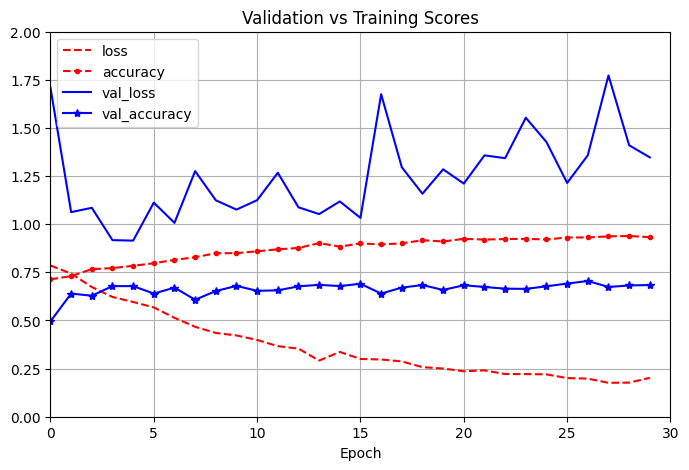

In [10]:
# Plot training vs validation accuracy and loss (indicates some issues)
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0,30], ylim=[0, 2], title="Validation vs Training Scores", grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [11]:
'''The remaining code is two attempts of transfer learning with CIFAR-10 model on STL-10 dataset.
 Neither attempt is finished (e.g., weight freezing wasn't completed).'''

# Load and clone model
orig_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CIFAR10_model')
orig_model_clone = keras.models.clone_model(orig_model)
orig_model_clone.set_weights(orig_model.get_weights())

# Define input shape
input_shape = X_train.shape[1:]

# Build function that converts Keras model to JSON file, then back to Keras
def change_model(model, new_input_shape = input_shape):
    model.layers[0].batch_input_shape = new_input_shape
    new_model = keras.models.model_from_json(model.to_json())

    for layer in new_model.layers:
        layer.set_weights(model.get_layer(name=layer.name).get_weights())
    return new_model
CIFAR_to_STL_model = change_model(orig_model_clone)

CIFAR_to_STL_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["categorical_accuracy"])
CIFAR_to_STL_model.summary()

CIFAR_to_STL_model.fit(X_train_full, y_train_full, epochs=30, callbacks=[early_stopping_cb])


loss, accuracy = CIFAR_to_STL_model.evaluate(X_test, y_test)
print('Loss:', round(loss, 2))
print('Accuracy:', round(accuracy, 2))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

ValueError: ignored

In [ ]:
# Another attempt of transfer learning with CIFAR-10 model on STL-10 dataset
orig_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CIFAR10_model')
orig_model_clone = keras.models.clone_model(orig_model)
orig_model_clone.set_weights(orig_model.get_weights())

# Create a new model
input_shape = (96, 96, 3)
new_input = keras.layers.Input(shape=input_shape)

# Map layers from the original CIFAR10 model to the new model
x = new_input
skip_next_conv = False
for layer in orig_model_clone.layers[1:]:
    if skip_next_conv:
        skip_next_conv = False
        continue
    if isinstance(layer, tf.keras.layers.Conv2D):
        x = tf.keras.layers.Conv2D(filters=3, kernel_size=layer.kernel_size, padding=layer.padding,
                                   activation=layer.activation, kernel_initializer=layer.kernel_initializer)(x)
        skip_next_conv = True
    else:
        x = layer(x)

x = tf.keras.layers.Flatten()(x)

# Add a new Dense layer with dynamic units based on the new input shape
dense_units = x.shape[-1]
x = tf.keras.layers.Dense(units=dense_units, activation='relu', kernel_initializer='he_normal')(x)

# Add a new output layer for STL10
output_layer = layers.Dense(units=9, activation='softmax', name="STL10_layer")(x)

# Create the new model
CIFAR_to_STL_model = models.Model(inputs=new_input, outputs=output_layer)

CIFAR_to_STL_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["categorical_accuracy"])
CIFAR_to_STL_model.summary()

CIFAR_to_STL_model.fit(X_train_full, y_train_full, epochs=30, callbacks=[early_stopping_cb])


loss, accuracy = CIFAR_to_STL_model.evaluate(X_test, y_test)
print('Loss:', round(loss, 2))
print('Accuracy:', round(accuracy, 2))